In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 9

In [2]:
file = ['katiestack/ngc1573_ellipsefit_9.txt', 'katiestack/ngc3379_ellipsefit_3.txt', 'katiestack/m101_ellipsefit_1.txt', 'katiestack/m94_ellipsefit_17.txt','katiestack/ngc7331_ellipsefit_7.txt']

# Starting Parameters
initial = np.array([(20,1,4)]*len(file)) #Assuming same starting parameters for each text file.
sppix = np.array([1.07, 0.93, 0.91,0.91,0.983])
markers = ["o", "^", "s", "d", "x"]
a = [0,0,2,2,2]

def Sersic(r, ue, re, n):
    b = 2*n - (1/3) + (4/(405*n)) + (46/(25515*n**2)) + (131/(1148175*n**3)) - (2194697/(30690717750*n**4))
    cn = (2.5/np.log(10))*b
    return ue + cn*((r/re)**(1/n) - 1)

def chisq(model_funct, model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - model_funct(x_data[i], *model_params))/y_err[i])**2 
    return chisqval

ngc1573 [20.16789169  1.1280894   3.88124259]
ngc1573 [0.18456096 0.09026758 0.2812281 ] 

ngc3379 [15.46895445  0.44220784  4.91757011]
ngc3379 [0.4238271  0.07534669 0.46509521] 

m101 [19.42570969  0.87623689  4.6201478 ]
m101 [0.84490313 0.32293243 1.93061424] 

m94 [16.35375114  0.81453679  5.14142893]
m94 [0.47730768 0.14713028 0.40349677] 

ngc7331 [18.14411842  1.16217321  4.30753956]
ngc7331 [0.29507613 0.13702748 0.30939287] 



C:\Users\Miles\AppData\Local\Temp\ipykernel_6508\3815989804.py:104: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(radius_s,bright,yerr=stddev*err, xerr=stddev*radius_err, fmt='o', markersize=1.5,


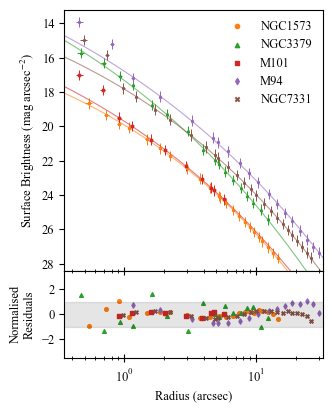

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw=dict(hspace=0), height_ratios=[3,1])
fig.set_figheight(4)
fig.set_figwidth(3.2)

# Reading Data
for i in range(len(file)):
    q = file[i].replace('/','_') # Replace / in the filename with _
    w = q.split('_') # Split up the filename with delimiter _ into a list
    name = w[1] # Name of the galaxy
    
# How many lines to skip to get data.
    data=open(file[i],'r')
    startdata='## Ellipse Parameters:'
    line = 2
    readline = True
    while readline:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == startdata:
            readline = False
        else:
            line = line + 1
    data.close()

# How many rows to read. Tried not closing/opening but code would hang.
    data=open(file[i],'r')
    points = '## Number of points:'
    l = 1
    readl = True
    while readl:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == points:
            readl = False
        else:
            l = l + 1

    npts=int(data.readline(l+1))
    data.close()

# Zero Point
    data=open(file[i],'r')
    zeropoint = '## Zero point of magnitude:'
    z = 1
    rl = True
    while rl:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == zeropoint:
            rl = False
        else:
            z = z + 1
        
    zpt = data.readline(z+1)
    zpt = float(zpt.strip()) # file has e.g. "25.8\n" which comes with an error - removes \n
    data.close()
    
    gaia=np.genfromtxt(file[i],skip_header=line, max_rows=npts)
    radius=gaia[:,3] # MeanRad column
    radius_s = radius*sppix[i]
    counts=gaia[:,4] # Count column
    mag=zpt - 2.5*np.log10(counts) 
    
    ell = gaia[:,6]
    area = np.pi*radius**2*ell
    bright = mag + 2.5*np.log10(area)

    dev = gaia[:,7] # Dev column
    zpterr = 0.1
    err = ((2.5 * dev/(np.log(10)*counts))**2 + zpterr**2)**(1/2)
    
    radius_err = 0.01*sppix[i]

    radius_s, bright, err = zip(*sorted(zip(radius_s, bright, err))) # Sorting data to not have weird line plots
    radius_s = np.array(radius_s)
    bright = np.array(bright)
    err = np.array(err)
    stddev = 3
    # How many std dev the error bars represent
    
    popt, cov = curve_fit(Sersic, # function to fit
                                    radius_s[a[i]:npts+1], # x data
                                    bright[a[i]:npts+1], # y data
                                    sigma=err[a[i]:npts+1], # set yerr as the array of error bars for the fit
                                    absolute_sigma=True, # errors bars DO represent 1 std error
                                    p0=initial[i], # starting point for fit
                                    check_finite=True, # raise ValueError if NaN encountered (don't allow errors to pass)
                                    maxfev=500000) 

    popt_errs = np.sqrt(np.diag(cov))
    
    # Residuals
    residuals = np.empty(len(radius))
    norm_r = np.empty(len(radius))
    for j in range(len(radius)):
        residuals[j] = bright[j] - Sersic(radius_s, *popt)[j]
        norm_r[j] = residuals[j]/err[j]

    fit_r = np.linspace(0.01, 40, 1000)
            
    print(name, popt)
    print(name, popt_errs, '\n')
        
    ax1.errorbar(radius_s,bright,yerr=stddev*err, xerr=stddev*radius_err, fmt='o', markersize=1.5,
                 color='C{}'.format(i+1), marker=markers[i], elinewidth = 0.7)
    # Note error bars are not 1 std dev
    
    ax1.scatter(radius_s,bright, s=1.5, color='C{}'.format(i+1), marker=markers[i], label=name.upper())
    # So that error bars don't show up in legend
    
    ax1.plot(fit_r, Sersic(fit_r, *popt), color='C{}'.format(i+1), alpha=0.6, lw=0.8)
    
    # Residual Plot
    ax2.scatter(radius_s, norm_r, s=7, color='C{}'.format(i+1), marker=markers[i])
    
ax1.set_ylim(13.2,28.4)
ax1.set_ylabel('Surface Brightness (mag arcsec$^{-2}$)')
ax1.invert_yaxis()
ax1.set_xscale("log")
ax1.set_xlim(0.35,32)
ax1.legend(loc='upper right', frameon=False, markerscale=2.5)

ax2.set_ylim(-3.5,3.5)
ax2.set_yticks([2,0,-2])
ax2.set_xlabel('Radius (arcsec)')
ax2.set_ylabel('Normalised\nResiduals')
ax2.fill_between(x=np.arange(0,100), y1=-1, y2=1, color ='black', alpha=0.1)
ax2.xaxis.set_tick_params(which='major', bottom=True, top=True, direction='inout', length=6)
ax2.xaxis.set_tick_params(which='minor', bottom=True, top=True, direction='inout', length=3)

fig.tight_layout(pad=0.3)

#fig.savefig('Plots/multiple.png', dpi=500)

In [ ]:
%history -g -f filename
